<a href="https://colab.research.google.com/github/yijunyang/database/blob/main/MIMIC3_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align='center' ><font size='5'>
BIS638 Clinical DMS & Ontology Project
</font></div>

<div align='center' ><font size='6'>
Ovarian Cancer EDA based on MIMIC III
</font></div>

<div align='center' ><font size='4'>
MPH '21 Yijun Yang
</font></div>

# 1. Introduction

*This project for Yale Course BIS 638: Clinical DMS and Ontologies.*

## 1.1 Background
- Ovarian cancer is the deadliest cancer of the female reproductive organs, outpacing all other forms of
gynecological cancer.

- According to data from national cancer institute, more than 20,000 new cases are estimated in 2020.

- About 1.4 percent of women will be diagnosed with ovarian cancer at some point during their lifetime.

<br/>

<div  align="center"> 
<img src="https://raw.githubusercontent.com/yijunyang/database/main/ovarian_cancer_statistics.png" width = "500" alt="img" align=center />

*Data source: National Cancer Institude*

</div>

<br/>

## 1.2 Research Questions
- Do an exploratory data analysis on patients who had ovarian cancer diagnoses:
  - Mortality
    - What’s the mortality of patients diagnosed with ovarian cancer?
    - What’s the average age of death?

  - ICU Stay
    - How long did these ovarian cancer patients stay in ICU?
    - Are there any differences in the average length of stay between those who survived and died?

- Standardize information using disease ontology:
    - ICD9 - DOID
      - Referring to previous homework, I have retrieved DOID for each icd9_code, and saved the information in `doid_icd9.csv` file.
    - DOID - Synonym
      - Referring to previous homework, I have retrieved different synonyms for each DOID, and saved the information in `synonym_full.csv` file.

<br/>

## 1.3 Data Sources
  - The data comes from [MIMIC-III](https://mimic.physionet.org/), an openly available dataset developed by the MIT Lab for Computational Physiology, comprising deidentified health data associated with ~60,000 intensive care unit admissions. It includes demographics, vital signs, laboratory tests, medications, and more.

<div  align="center"> 
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTeV6ahtZ6-POUjabTbHU973fbwmNAqleU5ag&usqp=CAU" width = "100" alt="img" />
</div>


  - To access MIMIC-III, I have finished [CITI Training for Data or Specimens Only Research](https://www.citiprogram.org/verify/?we5898f7f-6a38-4746-a119-3704dd3b4246-39864980). Data files have be downloaded and saved in google drive, and will be loaded into google colab.

<div  align="center"> 
<img src="https://raw.githubusercontent.com/yijunyang/database/main/CITI_certificate.png" width = "300" alt="img" />
</div>

<br/>

## 1.4 Methods 
<br/>
<img src="https://mark.trademarkia.com/logo-images/epoint-sa/vertabelo-86225942.jpg" height = "50" alt="img" />
<img src="https://d1.awsstatic.com/asset-repository/products/amazon-rds/1024px-MySQL.ff87215b43fd7292af172e2a5d9b844217262571.png" height = "50" alt="img" />
<img src="https://miro.medium.com/max/776/1*Lad06lrjlU9UZgSTHUoyfA.png" height = "50" alt="img" />
<img src="https://www.ebi.ac.uk/ols/img/OLS_logo_2017.png" height = "50" alt="img" />

<br/>

- Use [Vertabelo Database Modeler](https://vertabelo.com/) to design an ER model, then generate a MySQL script.
- Use google colab to install MySQL, read in SQL script and create a database with MIMIC III data.
- Use [OLS](https://www.ebi.ac.uk/ols/index) as an ontology resource, link the disease terms in Disease Ontology to the patient data representation (icd9_code).




# 2. Database Construction

## 2.1 Coding Environment Preparation

- Install MySQL

In [ ]:
!apt install mysql-server libmysqlclient-dev
!service mysql start
!mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY 'bis638'"
!pip install mysql-connector-python

- Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

- Require libraries

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

## 2.2 Data Resource

- The data files we will use include:
  - `PATIENTS`: Defines each SUBJECT_ID in the database, i.e. defines a single patient
  - `ADMISSIONS`: Define a patient’s hospital admission, HADM_ID
  - `DIAGNOSES_ICD`: Contains ICD diagnoses for patients, most notably ICD-9 diagnoses
  - `D_ICD_DIAGNOSES`: Definition table for ICD diagnoses
  - `ICUSTAYS`: Defines each ICUSTAY_ID in the database, i.e. defines a single ICU stay
  - `PRESCRIPTIONS`: Contains medication related order entries, i.e. prescriptions

- Create an ER model with Vertabelo:
![ER diagram](https://raw.githubusercontent.com/yijunyang/database/main/MIMIC3_Project_Physical_Model-2020-12-06_20-31.png)



- Use the `.sql` file generated from Vertabelo to construct the database:

In [ ]:
!mysql -u root -p -e "CREATE DATABASE IF NOT EXISTS mimic3;\
USE mimic3;\
SOURCE /content/gdrive/My Drive/mimic_iii/MIMIC3_Project_Physical_Model_create.sql;\
COMMIT;"

- Read in the `.csv` files into our database:

In [6]:
import mysql.connector
# establish a database connection with the load data file option set to True
cnx = mysql.connector.connect(user='root',
                password='bis638',
                host='127.0.0.1',
                database='mimic3',
                allow_local_infile=True)

# create database_cursor to perform SQL operation
db_cursor = cnx.cursor()

# execute the sql command to load a data file into a table (repeat the following line for more data files and tables)
db_cursor.execute("Load data local infile '/content/gdrive/My Drive/mimic_iii/PATIENTS.csv' into table PATIENTS fields terminated by ',' ignore 1 lines")
db_cursor.execute("Load data local infile '/content/gdrive/My Drive/mimic_iii/ADMISSIONS.csv' into table ADMISSIONS fields terminated by ',' ignore 1 lines")
db_cursor.execute("Load data local infile '/content/gdrive/My Drive/mimic_iii/ICUSTAYS.csv' into table ICUSTAYS fields terminated by ',' ignore 1 lines")
db_cursor.execute("Load data local infile '/content/gdrive/My Drive/mimic_iii/PRESCRIPTIONS.csv' into table PRESCRIPTIONS fields terminated by ',' ignore 1 lines")
db_cursor.execute("Load data local infile '/content/gdrive/My Drive/mimic_iii/D_ICD_DIAGNOSES.csv' into table D_ICD_DIAGNOSES fields terminated by ',' ignore 1 lines")
db_cursor.execute("Load data local infile '/content/gdrive/My Drive/mimic_iii/DIAGNOSES_ICD.csv' into table DIAGNOSES_ICD fields terminated by ',' ignore 1 lines")
db_cursor.execute("Load data local infile '/content/gdrive/My Drive/mimic_iii/DOID.csv' into table DOID fields terminated by ',' ignore 1 lines")
db_cursor.execute("Load data local infile '/content/gdrive/My Drive/mimic_iii/synonym_full.csv' into table SYNONYM fields terminated by ',' ignore 1 lines")

# commit the loading data transaction
db_cursor.execute("commit")

## 2.3 Ovarian Cancer Patients

- We want to extract information that only contains ovarian cancer patients.
  - First, we need to know what `icd9_code` represents ovarian cancer.

In [8]:
!mysql -u root -p -e "USE mimic3;\
SELECT * FROM D_ICD_DIAGNOSES \
WHERE (long_title LIKE '%OVARY%' OR long_title LIKE '%OVARIAN%') \
AND (long_title LIKE '%CANCER%' OR long_title LIKE '%NEOPLASM%');"

Enter password: 
+--------+-----------+----------------------------+---------------------------------------------------------+
| row_id | icd9_code | short_title                | long_title                                              |
+--------+-----------+----------------------------+---------------------------------------------------------+
|   1968 | "1830"    | "Malign neopl ovary"       | "Malignant neoplasm of ovary"                           |
|   2076 | "1986"    | "Second malig neo ovary"   | "Secondary malignant neoplasm of ovary"                 |
|   2471 | "220"     | "Benign neoplasm ovary"    | "Benign neoplasm of ovary"                              |
|   1724 | "2362"    | "Unc behav neo ovary"      | "Neoplasm of uncertain behavior of ovary"               |
|  13321 | "V1043"   | "Hx of ovarian malignancy" | "Personal history of malignant neoplasm of ovary"       |
|  10108 | "V1641"   | "Fm hx ovary malignancy"   | "Family history of malignant neoplasm of ovary"    

- After manully screening, we decide to include patients with `icd9_code` of `1830`, `1986`, and `V1043` as ovarian cancer patients.

- Extract all the ovarian cancer patients (but only show the first 20 records and selected parameters).

In [9]:
!mysql -u root -p -e "USE mimic3;\
CREATE TABLE IF NOT EXISTS ovarian_cancer AS \
  (SELECT a.subject_id, a.hadm_id, a.diagnosis, a.marital_status, a.ethnicity, a.hospital_expire_flag, di.icd9_code FROM ADMISSIONS AS a \
  INNER JOIN DIAGNOSES_ICD AS di \
  ON a.hadm_id = di.hadm_id \
  WHERE di.icd9_code IN ('\"1830\"', '\"1986\"', '\"V1043\"') \
  ORDER BY subject_id);"

Enter password: 


In [10]:
!mysql -u root -p -e "USE mimic3;\
SELECT o.subject_id, o.hadm_id, o.diagnosis, o.icd9_code, p.expire_flag FROM ovarian_cancer o \
INNER JOIN PATIENTS p ON o.subject_id = p.subject_id \
LIMIT 20;"

Enter password: 
+------------+---------+--------------------------------------------------+-----------+-------------+
| subject_id | hadm_id | diagnosis                                        | icd9_code | expire_flag |
+------------+---------+--------------------------------------------------+-----------+-------------+
|       1098 |  164266 | "ACUTE RENAL FAILURE"                            | "1830"    | 1           |
|       2577 |  120675 | "SMALL BOWEL OBSTRUCTION"                        | "V1043"   | 0           |
|       2577 |  199797 | "CI BLEED"                                       | "V1043"   | 0           |
|       2864 |  149239 | "PELVIC MASS/SDA"                                | "1830"    | 1           |
|       3167 |  168713 | "BRAIN METASTASIS"                               | "V1043"   | 1           |
|       3710 |  138509 | "ICH;TELEMETRY"                                  | "V1043"   | 0           |
|       3867 |  140636 | "OVARIAN CANCER"                        

- There are in total 169 patients in MIMIC3 database who had ovarian cancer, and they made about 200 admissions in total.

In [ ]:
!mysql -u root -p -e "USE mimic3;\
SELECT COUNT(DISTINCT subject_id) AS ovarian_cancer_subject, COUNT(DISTINCT hadm_id) AS ovarian_cancer_admission FROM ovarian_cancer;"

Enter password: 
+------------------------+--------------------------+
| ovarian_cancer_subject | ovarian_cancer_admission |
+------------------------+--------------------------+
|                    169 |                      201 |
+------------------------+--------------------------+


# 3. Exploratory Data Analysis

## 3.1 Mortality

- First, we want to learn about the mortality rate of ovarian cancer.
  - Use a pie chart to intuitively show the percentage.


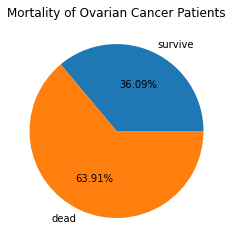

In [11]:
sql_statement = "SELECT expire_flag FROM PATIENTS \
WHERE subject_id in (SELECT DISTINCT subject_id FROM ovarian_cancer)"

db_cursor.execute(sql_statement)
dbresult = db_cursor.fetchall()
death_indicator = []
for r in dbresult:
  death_indicator.append(r[0])

# print(death_indicator)
survive = death_indicator.count('0')
death = death_indicator.count('1')

plt.pie([survive, death], labels = ['survive', 'dead'], autopct = '%1.2f%%')
plt.title('Mortality of Ovarian Cancer Patients')
plt.show()

- Then, we want to know the average age of those who died. 
  - Before the calculation, take a look at each patient's death age.
  - Some patients has a death age of 300, which is obviously impossible. Therefore, we do not account for this patient in our following analysis.
  - Only show the first 20 records here.

In [13]:
!mysql -u root -p -e "USE mimic3;\
SELECT subject_id, dob, dod, round(left((dod-dob), length(dod-dob)-8)/100) AS expire_age FROM PATIENTS \
WHERE subject_id in (SELECT DISTINCT subject_id FROM ovarian_cancer) \
AND expire_flag = 1 \
LIMIT 20;"

Enter password: 
+------------+---------------------+---------------------+------------+
| subject_id | dob                 | dod                 | expire_age |
+------------+---------------------+---------------------+------------+
|       1098 | 2138-02-10 00:00:00 | 2198-07-31 00:00:00 |         60 |
|       2864 | 2111-02-07 00:00:00 | 2165-07-26 00:00:00 |         54 |
|       3167 | 2078-08-30 00:00:00 | 2152-05-30 00:00:00 |         74 |
|       3867 | 2055-07-28 00:00:00 | 2125-11-09 00:00:00 |         70 |
|       4178 | 2088-04-05 00:00:00 | 2144-10-10 00:00:00 |         56 |
|       5437 | 2140-05-07 00:00:00 | 2198-07-22 00:00:00 |         58 |
|       6552 | 2073-06-01 00:00:00 | 2116-02-04 00:00:00 |         43 |
|       6638 | 2127-02-22 00:00:00 | 2164-07-19 00:00:00 |         37 |
|       6691 | 2040-04-12 00:00:00 | 2116-01-18 00:00:00 |         76 |
|       7023 | 2094-04-28 00:00:00 | 2160-07-31 00:00:00 |         66 |
|       7037 | 2046-03-03 00:00:00 | 2130-06-03

  - Use a histgram to intuitively show the pattern.

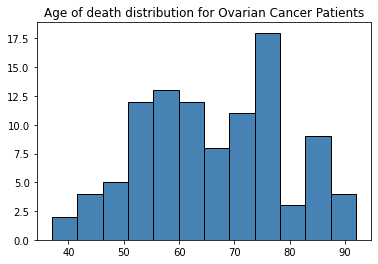

In [14]:
sql_statement = "SELECT round(left((dod-dob), length(dod-dob)-8)/100) AS expire_age FROM PATIENTS \
WHERE subject_id in (SELECT DISTINCT subject_id FROM ovarian_cancer) \
AND expire_flag = 1 \
AND left((dod-dob), length(dod-dob)-8)/100 < 100"

db_cursor.execute(sql_statement)
dbresult = db_cursor.fetchall()
ages = []
for r in dbresult:
  ages.append(r[0])

plt.hist(ages, bins = 12, color = 'steelblue', edgecolor = 'k')
plt.title('Age of death distribution for Ovarian Cancer Patients')
plt.show()

- Calculate the average expire age.

In [15]:
!mysql -u root -p -e "USE mimic3;\
SELECT round(AVG(left((dod-dob), length(dod-dob)-8)/100)) AS avg_expire_age FROM PATIENTS \
WHERE subject_id in (SELECT DISTINCT subject_id FROM ovarian_cancer) \
AND expire_flag = 1 \
AND left((dod-dob), length(dod-dob)-8)/100 < 100;"

Enter password: 
+----------------+
| avg_expire_age |
+----------------+
|             66 |
+----------------+


## 3.2 ICU Stay
- We want to know whether these patients diagnosed with ovrian cancer had ICU experiences.
  - How long did they stay?
  - Are there any differences in the length of stay between those who survived and died?


- First, calculate the lenth of stay for each ICU admission.
  - Only show the first 20 records here.

In [16]:
!mysql -u root -p -e "USE mimic3;\
CREATE TABLE IF NOT EXISTS ovarian_icu AS \
  (SELECT i.subject_id, i.hadm_id, i.icustay_id, i.los, p.expire_flag FROM ADMISSIONS AS a \
  LEFT JOIN ICUSTAYS AS i ON i.hadm_id = a.hadm_id \
  LEFT JOIN PATIENTS AS p ON p.subject_id = a.subject_id \
  WHERE i.hadm_id in (SELECT hadm_id FROM ovarian_cancer)); \
SELECT * FROM ovarian_icu \
LIMIT 20;"

Enter password: 
+------------+---------+------------+--------+-------------+
| subject_id | hadm_id | icustay_id | los    | expire_flag |
+------------+---------+------------+--------+-------------+
|       1098 |  164266 |     260567 | 3.6425 | 1           |
|       2577 |  120675 |     264032 |  1.871 | 0           |
|       2577 |  199797 |     231757 | 0.6397 | 0           |
|       2864 |  149239 |     274525 | 0.7218 | 1           |
|       3167 |  168713 |     258151 | 0.9958 | 1           |
|       3710 |  138509 |     287396 | 4.0004 | 0           |
|       3867 |  140636 |     216111 | 7.8158 | 1           |
|       4178 |  138402 |     239805 |  0.934 | 1           |
|       6423 |  108232 |     293909 | 3.0787 | 0           |
|       6552 |  103859 |     257694 | 5.5905 | 1           |
|       6552 |  116827 |     219257 |  2.409 | 1           |
|       6552 |  162786 |     239486 | 1.5497 | 1           |
|       6638 |  129351 |     220552 | 0.8601 | 1           |
|      

- Note that some patients may stay in ICU for several times.
  - Therefore, we want to modify the above table, to calculate a total stay length for each subject.
  - Only show the first 20 records here.

In [17]:
!mysql -u root -p -e "USE mimic3;\
CREATE TABLE IF NOT EXISTS ovarian_los AS \
  (SELECT oi.subject_id, ROUND(SUM(oi.los), 1) AS total_los, p.expire_flag FROM ovarian_icu AS oi \
  INNER JOIN PATIENTS AS p ON oi.subject_id = p.subject_id \
  GROUP BY subject_id); \
SELECT * FROM ovarian_los \
LIMIT 20;"

Enter password: 
+------------+-----------+-------------+
| subject_id | total_los | expire_flag |
+------------+-----------+-------------+
|       1098 |       3.6 | 1           |
|       2577 |       2.5 | 0           |
|       2864 |       0.7 | 1           |
|       3167 |       1.0 | 1           |
|       3710 |       4.0 | 0           |
|       3867 |       7.8 | 1           |
|       4178 |       0.9 | 1           |
|       6423 |       3.1 | 0           |
|       6552 |       9.5 | 1           |
|       6638 |       1.5 | 1           |
|       6691 |       1.8 | 1           |
|       7023 |       2.1 | 1           |
|       7037 |       9.7 | 1           |
|       7193 |       0.9 | 0           |
|       7478 |       1.0 | 1           |
|       7764 |       0.8 | 1           |
|       7862 |       1.0 | 1           |
|       7955 |       5.9 | 1           |
|       7957 |       1.0 | 1           |
|       8276 |       1.8 | 1           |
+------------+-----------+-------------+

- The average length of stay in ICU is 3.3 days for the survived and 4.7 for the died.

In [ ]:
!mysql -u root -p -e "USE mimic3;\
SELECT expire_flag, ROUND(AVG(total_los),1) AS average_los FROM ovarian_los GROUP BY expire_flag;"

Enter password: 
+-------------+-------------+
| expire_flag | average_los |
+-------------+-------------+
| 0           |         3.3 |
| 1           |         4.7 |
+-------------+-------------+


- We want to do a statistical test to see if there is a significant difference between those who survived and died.

In [18]:
### need to close the cursor and reconnect to avoid potential bug
db_cursor.close()
cnx.close()
import mysql.connector
cnx = mysql.connector.connect(user='root', password='bis638', host='127.0.0.1', database='mimic3', allow_local_infile=True)
db_cursor = cnx.cursor()

sql_statement = "SELECT * FROM ovarian_los"
db_cursor.execute(sql_statement)
dbresult = db_cursor.fetchall()

# initiate a temporary list to save the dictionaries
tmp = []
# initiate an index
i = 0

for r in dbresult:
  LOS = {}
  LOS['subject_id'] = r[0]
  LOS['total_los'] = r[1]
  LOS['expire_flag'] = r[2]
  
  # save the value of dictionary in the list
  tmp.append(LOS.values())
  i = i + 1

df = pd.DataFrame(columns = ['subject_id', 'total_los', 'expire_flag'], data = tmp)
rvs1 = df.loc[df["expire_flag"] == "1", ["total_los"]]
rvs0 = df.loc[df["expire_flag"] == "0", ["total_los"]]

In [19]:
# Do the levene test to assess the equality of variances
stats.levene(rvs1['total_los'], rvs0['total_los'])

LeveneResult(statistic=1.9990433182474632, pvalue=0.15928251771075227)

In [20]:
# LeveneResult p > 0.05, we can assume that variances are the same
# Do the t test
stats.ttest_ind(rvs1['total_los'], rvs0['total_los'])

Ttest_indResult(statistic=1.523764151362712, pvalue=0.12948197260712796)

- p = 0.13 > 0.05, we fail to reject the null hypothesis and conclude that there is no significant difference in average length of ICU stay between those who survived and those who died.

# 4. Ontology

- I tried to retrieve the DOID for each icd9_code, but turned out there was no corresponding DOID for secondary malignant neoplasm of ovary and personal history of ovarian neoplasm.

In [21]:
!mysql -u root -p -e "USE mimic3;\
CREATE TABLE IF NOT EXISTS ovarian_syn AS \
  (SELECT DISTINCT did.icd9_code, did.short_title, did.long_title, DOID.DOID, SYNONYM.label, SYNONYM.synonym FROM D_ICD_DIAGNOSES AS did \
  LEFT JOIN DOID ON did.icd9_code = DOID.icd9_code \
  LEFT JOIN SYNONYM ON DOID.DOID = SYNONYM.DOID \
  WHERE did.icd9_code LIKE '_1830_' \
  OR did.icd9_code LIKE '_1986_' \
  OR did.icd9_code LIKE '_V1043_'); \
SELECT * FROM ovarian_syn;"

Enter password: 
+-----------+----------------------------+---------------------------------------------------+------+----------------+---------------------------+
| icd9_code | short_title                | long_title                                        | DOID | label          | synonym                   |
+-----------+----------------------------+---------------------------------------------------+------+----------------+---------------------------+
| "1830"    | "Malign neopl ovary"       | "Malignant neoplasm of ovary"                     | 2394 | ovarian cancer | malignant tumour of ovary |
| "1830"    | "Malign neopl ovary"       | "Malignant neoplasm of ovary"                     | 2394 | ovarian cancer | ovarian neoplasm          |
| "1830"    | "Malign neopl ovary"       | "Malignant neoplasm of ovary"                     | 2394 | ovarian cancer | tumor of the Ovary        |
| "1830"    | "Malign neopl ovary"       | "Malignant neoplasm of ovary"                     | 2394 |

- Here comes the problem: 
  - When I try to retrieve patients with **malignant tumour of ovary**, not only patients with `icd9_code = 1830` meet the criteria; I also want to retrieve patients with `icd9_code = 1986`.
  - But when I try to retrieve patients with **primary ovarian cancer**, I do not want patients with `icd9_code = 1986 (Secondary malignant neoplasm of ovary)`.
- Therefore, I would like to do a little modification to the above table.

In [22]:
!mysql -u root -p -e "USE mimic3;\
START TRANSACTION; \
INSERT INTO ovarian_syn VALUES ('\"1986\"', 'Second malig neo ovary', 'Secondary malignant neoplasm of ovary', 'NULL', 'NULL', 'malignant tumour of ovary'); \
INSERT INTO ovarian_syn VALUES ('\"1986\"', 'Second malig neo ovary', 'Secondary malignant neoplasm of ovary', 'NULL', 'NULL', 'ovarian neoplasm'); \
INSERT INTO ovarian_syn VALUES ('\"1986\"', 'Second malig neo ovary', 'Secondary malignant neoplasm of ovary', 'NULL', 'NULL', 'tumor of the Ovary'); \
INSERT INTO ovarian_syn VALUES ('\"1986\"', 'Second malig neo ovary', 'Secondary malignant neoplasm of ovary', 'NULL', 'NULL', 'malignant Ovarian tumor'); \
INSERT INTO ovarian_syn VALUES ('\"1986\"', 'Second malig neo ovary', 'Secondary malignant neoplasm of ovary', 'NULL', 'NULL', 'ovary neoplasm'); \
COMMIT; \
SELECT * FROM ovarian_syn WHERE synonym NOT IN ('NULL');"

Enter password: 
+-----------+------------------------+---------------------------------------+------+----------------+---------------------------+
| icd9_code | short_title            | long_title                            | DOID | label          | synonym                   |
+-----------+------------------------+---------------------------------------+------+----------------+---------------------------+
| "1830"    | "Malign neopl ovary"   | "Malignant neoplasm of ovary"         | 2394 | ovarian cancer | malignant tumour of ovary |
| "1830"    | "Malign neopl ovary"   | "Malignant neoplasm of ovary"         | 2394 | ovarian cancer | ovarian neoplasm          |
| "1830"    | "Malign neopl ovary"   | "Malignant neoplasm of ovary"         | 2394 | ovarian cancer | tumor of the Ovary        |
| "1830"    | "Malign neopl ovary"   | "Malignant neoplasm of ovary"         | 2394 | ovarian cancer | primary ovarian cancer    |
| "1830"    | "Malign neopl ovary"   | "Malignant neoplasm of ovar

- Finally, we can use synonyms to retrieve corresponding subjects and admissions as we expected.
  - Sample code as below (the results are too long so I hide them).

In [ ]:
!mysql -u root -p -e "USE mimic3;\
SELECT diag.subject_id, diag.hadm_id, diag.icd9_code FROM ovarian_syn s \
INNER JOIN DIAGNOSES_ICD diag on s.icd9_code = diag.icd9_code \
WHERE s.synonym = 'malignant tumour of ovary';" 

# 5. Reference & Acknowlegement

- Some part of inspirations comes from [44 Statistics to Know
About Ovarian Cancer](https://www.asbestos.com/cancer/ovarian/ovarian-cancer-statistics/#:~:text=The%20median%20age%20of%20patients%20who%20die%20from%20ovarian%20cancer%20is%2070.&text=About%20half%20of%20ovarian%20cancer,women%20ages%2063%20and%20older.).

- Thanks to Kei-Hoi, David, and Vimig, for this fantastic, brand-new course.